# Importing relevant libraries

In [7]:
import pandas as pd # For loading the dataframe
import matplotlib.pyplot as plt # For plotting the graphs
import pickle # For saving and loading
import numpy as np
import seaborn as sns # For the confusion matrix

import nltk # Used for preprocessing
import string # Used for preprocessing
from nltk.tokenize import word_tokenize # Used for preprocessing
from nltk.corpus import stopwords # Used for preprocessing
from nltk.stem   import WordNetLemmatizer # Used for preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer # Used for word embedding for NN
from tensorflow.keras.preprocessing.sequence import pad_sequences # Used for word embedding for NN

from sklearn.model_selection import train_test_split # For splitting the data
from tensorflow.keras.models import Sequential, model_from_json # Used for building and loading the RNN-LSTM
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense # Used for building the RNN-LSTM

from sklearn.metrics import classification_report # Used for model evaluation
from sklearn.metrics import confusion_matrix # Used for model evaluation

# Loading the data

In [33]:
# Loading the dataset
df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)
df = df.dropna()

# Preprocessing the data

In [34]:
# Preprocessing function

def preprocess_text(text):
    text = ''.join([c for c in text if c not in string.punctuation and c not in string.digits])
    tokens = word_tokenize(text, 'english')
    lowered = [x.lower() for x in tokens] # new
    lemmatiser = WordNetLemmatizer()
    lemmatized = [lemmatiser.lemmatize(word) for word in lowered] # Adjusted
    sw = stopwords.words('english')
    stopped = [word for word in lemmatized if word.lower() not in sw]
    return stopped

In [35]:
X = df['text']
y = df['label']

In [36]:
X_store = []
for i in X[:]:
    X_store.append(preprocess_text(i))
X = X_store

# Feature extraction

In [37]:
max_features = 512 # Max words in the vectors
tokenizer = Tokenizer(num_words = max_features) # Tokenizing the text into numbers
tokenizer.fit_on_texts(texts = X) # Building the vocabulary
X_2 = tokenizer.texts_to_sequences(texts = X) # Tokenized words as X data from the train dataset

In [38]:
X = pad_sequences(sequences = X_2, maxlen = max_features, padding = 'pre') # Padding the X data to 4500
y = y.values # Subsetting the y data from the train dataset

# Splitting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101) # Separating train data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 101) # Separating train data

# Tuning the model

In [9]:
def create_model():
    model = Sequential()
    model.add(layer = Embedding(input_dim = max_features, output_dim = 128, name = '1st_layer'))
    model.add(layer = LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2, name = '2nd_layer'))
    model.add(layer = Dropout(rate = 0.5, name = '3rd_layer'))
    model.add(layer = Dense(units = 64,  activation = 'relu', name = '4th_layer'))
    model.add(layer = Dropout(rate = 0.5, name = '5th_layer'))
    model.add(layer = Dense(units = 1,  activation = 'sigmoid', name = 'output_layer'))
    model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])
    return model

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Preparing
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, verbose = 0)

# Implementing the hyperparameters in Grid Search
batch_size = [16, 32, 64]
epochs = [10]#, 25, 50
param_grid = dict(batch_size=batch_size, epochs = epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X_train, y_train)

# Printing results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<ipython-input-12-9f2b313fe0ec>:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose = 0)


Best: 0.963567 using {'batch_size': 16, 'epochs': 10}
0.963567 (0.001345) with: {'batch_size': 16, 'epochs': 10}
0.960981 (0.003198) with: {'batch_size': 32, 'epochs': 10}
0.952751 (0.001886) with: {'batch_size': 64, 'epochs': 10}


# Training the model

In [121]:
# LSTM Neural Network
lstm_model = Sequential(name = 'lstm_nn_model')
lstm_model.add(layer = Embedding(input_dim = max_features, output_dim = 128, name = '1st_layer'))
lstm_model.add(layer = LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2, name = '2nd_layer'))
lstm_model.add(layer = Dropout(rate = 0.5, name = '3rd_layer'))
lstm_model.add(layer = Dense(units = 64,  activation = 'relu', name = '4th_layer'))
lstm_model.add(layer = Dropout(rate = 0.5, name = '5th_layer'))
lstm_model.add(layer = Dense(units = 1,  activation = 'sigmoid', name = 'output_layer'))
# compiling the model
lstm_model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])

In [122]:
lstm_model.summary()

Model: "lstm_nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_layer (Embedding)       (None, None, 128)         65536     
                                                                 
 2nd_layer (LSTM)            (None, 128)               131584    
                                                                 
 3rd_layer (Dropout)         (None, 128)               0         
                                                                 
 4th_layer (Dense)           (None, 64)                8256      
                                                                 
 5th_layer (Dropout)         (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 205,441
Trainable params: 205,441
Non-t

In [124]:
history = lstm_model.fit(X_train, y_train, validation_data = [X_val, y_val], epochs = 20, batch_size = 64)
# Changed amount of epochs

Epoch 1/20
895/895 [==============================] - 2865s 3s/step - loss: 0.2515 - accuracy: 0.9084 - val_loss: 0.2213 - val_accuracy: 0.9175
Epoch 2/20
895/895 [==============================] - 2873s 3s/step - loss: 0.1917 - accuracy: 0.9306 - val_loss: 0.1587 - val_accuracy: 0.9431
Epoch 3/20
895/895 [==============================] - 33922s 38s/step - loss: 0.1722 - accuracy: 0.9366 - val_loss: 0.1620 - val_accuracy: 0.9402
Epoch 4/20
895/895 [==============================] - 14572s 16s/step - loss: 0.2224 - accuracy: 0.9200 - val_loss: 0.1906 - val_accuracy: 0.9275
Epoch 5/20
895/895 [==============================] - 4288s 5s/step - loss: 0.2163 - accuracy: 0.9158 - val_loss: 0.1369 - val_accuracy: 0.9491
Epoch 6/20
895/895 [==============================] - 3770s 4s/step - loss: 0.1312 - accuracy: 0.9545 - val_loss: 0.1182 - val_accuracy: 0.9565
Epoch 7/20
895/895 [==============================] - 1329s 1s/step - loss: 0.1104 - accuracy: 0.9621 - val_loss: 0.1122 - val_accur

# Save the history
pickle.dump(history, open("history.p_2.0", "wb"))

# Serialize model to JSON
lstm_model_json = lstm_model.to_json()
with open("lstm_model.json_2.0", "w") as json_file:
    json_file.write(lstm_model_json)
    
# Serialize weights to HDF5
lstm_model.save_weights("lstm_model.h5_2.0")
print("Saved model to disk")

In [5]:
# Load the history
history = pickle.load(open("history.p_2.0", "rb"))

# Load json and create model
json_file = open('lstm_model.json_2.0', 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(loaded_model_json)

# Load weights into model
lstm_model.load_weights("lstm_model.h5_3.0")

# Compile the model
lstm_model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])

# Print for checking for success
print("Loaded model from disk")


Loaded model from disk


In [15]:
train_loss, train_acc = lstm_model.evaluate(X_train, y_train)
print("train loss : ", train_loss)
print("train accuracy : ", train_acc)

test_loss, test_acc = lstm_model.evaluate(X_test, y_test)
print("test loss : ", test_loss)
print("test accuracy : ", test_acc)

1789/1789 [==============================] - 439s 245ms/step - loss: 0.0102 - accuracy: 0.9969
train loss :  0.010156123898923397
train accuracy :  0.9968897104263306
224/224 [==============================] - 55s 247ms/step - loss: 0.1558 - accuracy: 0.9719
test loss :  0.15576404333114624
test accuracy :  0.9719038009643555


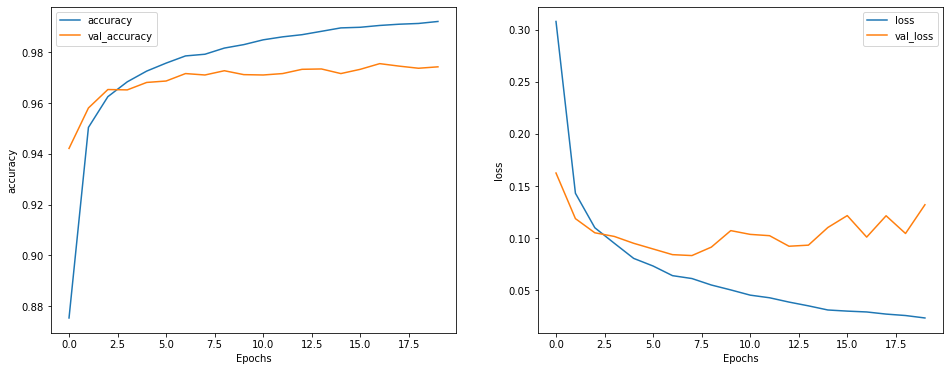

In [16]:
# plot the train/validation loss and accuracy
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [17]:
cont_test_pred = lstm_model.predict(X_test)
y_test_pred = np.where(cont_test_pred >= 0.5, 1, 0)

224/224 [==============================] - 64s 283ms/step


In [18]:
pd.DataFrame(classification_report(y_test, y_test_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.977444,0.966721,0.971904,0.972082,0.971971
recall,0.964887,0.978636,0.971904,0.971762,0.971904
f1-score,0.971125,0.972642,0.971904,0.971883,0.971899
support,3503.000000,3651.000000,0.971904,7154.000000,7154.000000


Text(51.0, 0.5, 'Real Labels')

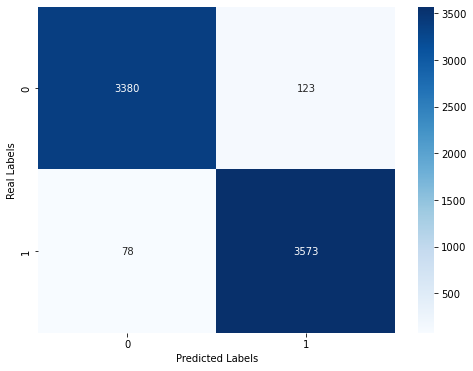

In [19]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

# Per sub-dataset

In [39]:
df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)

df_kaggle = df.loc[:20799]
df_McIntire = df.loc[20800:27134]
df_Reuters = df.loc[27135:72032]
df_Buzzfeed = df.loc[72033:]

df_kaggle = df_kaggle.dropna()
df_McIntire = df_McIntire.dropna()
df_Reuters = df_Reuters.dropna()
df_Buzzfeed = df_Buzzfeed.dropna()

print("Nr. of news articles in Kaggle :", len(df_kaggle))
print("Nr. of news articles in McIntire :", len(df_McIntire))
print("Nr. of news articles in Reuters :", len(df_Reuters))
print("Nr. of news articles in Buzzfeed :", len(df_Buzzfeed))

Nr. of news articles in Kaggle : 20664
Nr. of news articles in McIntire : 6285
Nr. of news articles in Reuters : 44487
Nr. of news articles in Buzzfeed : 101


In [40]:
df_kaggle_y = df_kaggle.iloc[:, 2]
df_kaggle_x = df_kaggle.iloc[:, 1]
df_McIntire_y = df_McIntire.iloc[:, 2]
df_McIntire_x = df_McIntire.iloc[:, 1]
df_Reuters_y = df_Reuters.iloc[:, 2]
df_Reuters_x = df_Reuters.iloc[:, 1]
df_Buzzfeed_y = df_Buzzfeed.iloc[:, 2]
df_Buzzfeed_x = df_Buzzfeed.iloc[:, 1]

# Kaggle sub-dataset

In [41]:
X_store = []
for i in df_kaggle_x[:]:
    X_store.append(preprocess_text(i))
X = X_store
X_2 = tokenizer.texts_to_sequences(texts = X) # Tokenized words as X data from the train dataset

kaggle_X = pad_sequences(sequences = X_2, maxlen = max_features, padding = 'pre') # Padding the X data to 4500
kaggle_y = df_kaggle_y.values # Subsetting the y data from the train dataset

In [42]:
kaggle_pred = lstm_model.predict(kaggle_X)
kaggle_y_pred = np.where(kaggle_pred >= 0.5, 1, 0)

646/646 [==============================] - 155s 240ms/step


In [43]:
pd.DataFrame(classification_report(kaggle_y, kaggle_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.992680,0.991489,0.992063,0.992084,0.992065
recall,0.990891,0.993161,0.992063,0.992026,0.992063
f1-score,0.991784,0.992324,0.992063,0.992054,0.992063
support,9990.000000,10674.000000,0.992063,20664.000000,20664.000000


Text(51.0, 0.5, 'Real Labels')

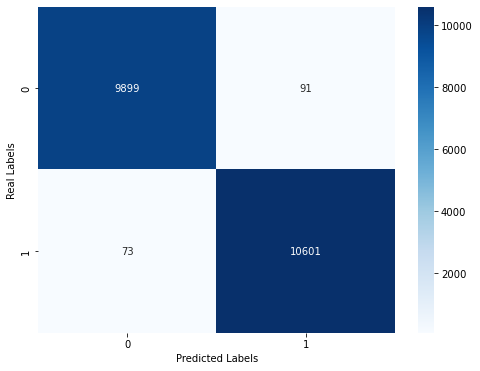

In [44]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(kaggle_y, kaggle_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

# McIntire

In [45]:
X_store = []
for i in df_McIntire_x[:]:
    X_store.append(preprocess_text(i))
X = X_store
X_2 = tokenizer.texts_to_sequences(texts = X) # Tokenized words as X data from the train dataset

McIntire_X = pad_sequences(sequences = X_2, maxlen = max_features, padding = 'pre') # Padding the X data to 4500
McIntire_y = df_McIntire_y.values # Subsetting the y data from the train dataset

In [48]:
McIntire_pred = lstm_model.predict(McIntire_X)
McIntire_y_pred = np.where(McIntire_pred >= 0.5, 1, 0)

197/197 [==============================] - 44s 225ms/step


In [49]:
pd.DataFrame(classification_report(McIntire_y, McIntire_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.993117,0.991342,0.992204,0.992230,0.992206
recall,0.990844,0.993492,0.992204,0.992168,0.992204
f1-score,0.991979,0.992416,0.992204,0.992198,0.992203
support,3058.000000,3227.000000,0.992204,6285.000000,6285.000000


Text(51.0, 0.5, 'Real Labels')

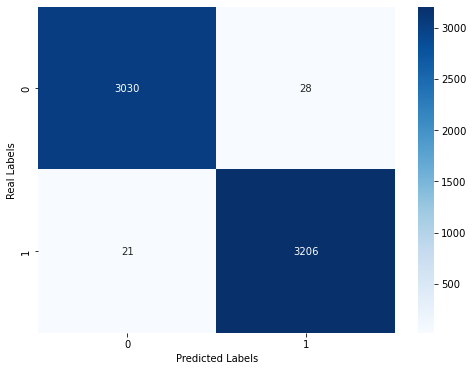

In [50]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(McIntire_y, McIntire_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

# Reuters

In [51]:
X_store = []
for i in df_Reuters_x[:]:
    X_store.append(preprocess_text(i))
X = X_store
X_2 = tokenizer.texts_to_sequences(texts = X) # Tokenized words as X data from the train dataset

Reuters_X = pad_sequences(sequences = X_2, maxlen = max_features, padding = 'pre') # Padding the X data to 4500
Reuters_y = df_Reuters_y.values # Subsetting the y data from the train dataset

In [53]:
Reuters_pred = lstm_model.predict(Reuters_X)
Reuters_y_pred = np.where(Reuters_pred >= 0.5, 1, 0)

1391/1391 [==============================] - 357s 257ms/step


In [54]:
pd.DataFrame(classification_report(Reuters_y, Reuters_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.994321,0.990024,0.992133,0.992172,0.992142
recall,0.989697,0.994502,0.992133,0.992099,0.992133
f1-score,0.992003,0.992258,0.992133,0.992130,0.992132
support,21935.000000,22552.000000,0.992133,44487.000000,44487.000000


Text(51.0, 0.5, 'Real Labels')

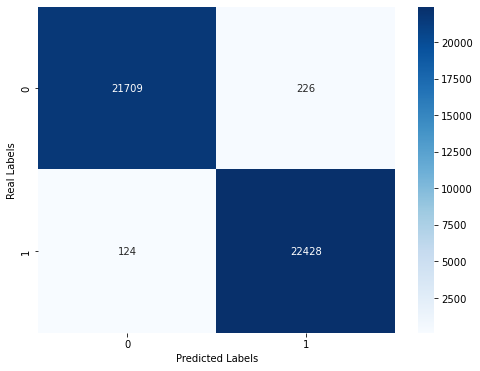

In [55]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(Reuters_y, Reuters_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

# Buzzfeed

In [56]:
X_store = []
for i in df_Buzzfeed_x[:]:
    X_store.append(preprocess_text(i))
X = X_store
X_2 = tokenizer.texts_to_sequences(texts = X) # Tokenized words as X data from the train dataset

Buzzfeed_X = pad_sequences(sequences = X_2, maxlen = max_features, padding = 'pre') # Padding the X data to 4500
Buzzfeed_y = df_Buzzfeed_y.values # Subsetting the y data from the train dataset

In [57]:
Buzzfeed_pred = lstm_model.predict(Buzzfeed_X)
Buzzfeed_y_pred = np.where(Buzzfeed_pred >= 0.5, 1, 0)

4/4 [==============================] - 1s 212ms/step


In [58]:
pd.DataFrame(classification_report(Buzzfeed_y, Buzzfeed_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,45.0,56.0,1.0,101.0,101.0


Text(51.0, 0.5, 'Real Labels')

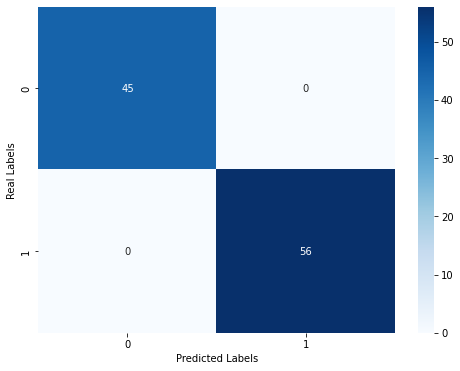

In [59]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(Buzzfeed_y, Buzzfeed_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')